# P1 - TSA - Acceso a Internet en Colombia

Elaborado por GRUPO 1:
- Juanita Piraban Barbosa - 201216313
- Lorena Morales Rodríguez - 202027957
- Alejandro Barinas Guio - 201628859
- Jaime Humberto Trujillo Perea - 201920366
- Alexander Zapata Galindo - 201425426

In [7]:
# Importar Librerias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import sys
import plotly as pt
import plotly.express as px
import warnings

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from matplotlib import pyplot
from pandas import DatetimeIndex

%matplotlib inline
sns.set()  


# Parte A. Contexto y relevancia del problema

### $\color{red}{\text{TODOS}}$ 

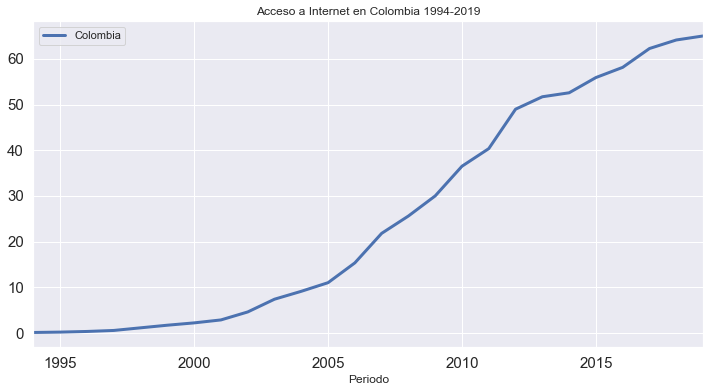

In [91]:
# Leer el archivo 'datos.csv'
df = pd.read_excel("DataSet/P1_Serie_Acceso_Internet.xlsx",index_col=0)
df.plot(figsize=(12, 6),linewidth=3, fontsize=15, title='Acceso a Internet en Colombia 1994-2019');

# Parte B. Análisis de los principales componentes de la serie

### $\color{red}{\text{JAIME}}$ 

# Estacionariedad

In [24]:
#DF Test
result = adfuller(df['Colombia'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 2.702899
p-value: 0.999087
Critical Values:
	1%: -3.924
	5%: -3.068
	10%: -2.674


En este caso, el test no rechaza la Ho de que la serie no es estacionaria.

# Tendencia

# Estacionalidad

# Parte C. Modelos y Proyecciones

## Modelos ARIMA

### $\color{red}{\text{JUANITA-ALEX}}$ 

Se transforma la serie en logaritmo y se diferencia una vez:

In [68]:
df['log_Colombia'] = np.log(df['Colombia'])
df

df_log=df.iloc[:,1:3]
df_log= df.log_Colombia.diff()
df_log=df_log.dropna()
df_log.describe()

count    25.000000
mean      0.256312
std       0.202557
min       0.013638
25%       0.068524
50%       0.196115
75%       0.410421
max       0.715762
Name: log_Colombia, dtype: float64

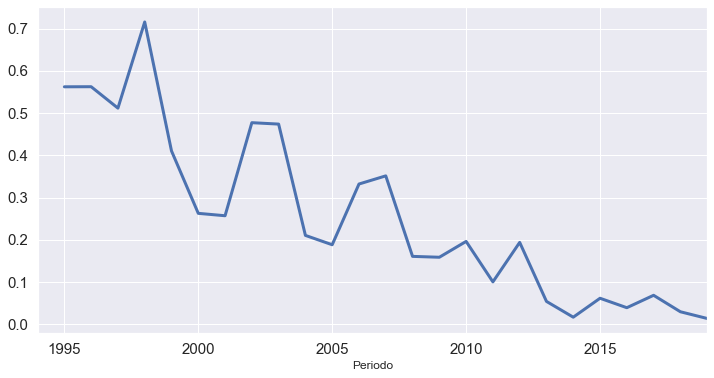

In [46]:
df_log.plot(figsize=(12, 6),linewidth=3, fontsize=15);

In [79]:
result = adfuller(df_log)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.834710
p-value: 0.808713
Critical Values:
	1%: -3.889
	5%: -3.054
	10%: -2.667


La serie sigue siendo no estacionaria. Luego se diferencia una vez más.

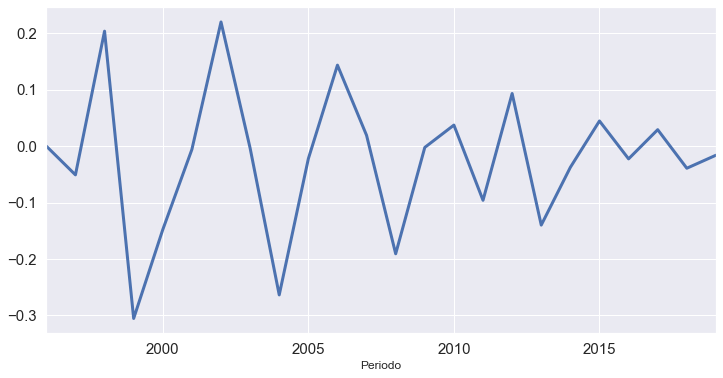

In [84]:
df_log_1= df_log.diff()
df_log_1=df_log_1.dropna()
df_log_1.plot(figsize=(12, 6),linewidth=3, fontsize=15);

In [85]:
result = adfuller(df_log_1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.201151
p-value: 0.673100
Critical Values:
	1%: -4.012
	5%: -3.104
	10%: -2.691


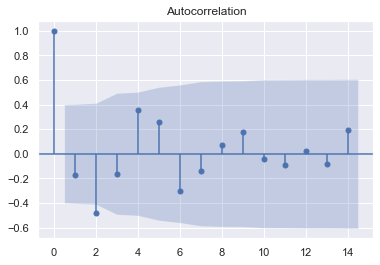

In [86]:
# Función de Autocorrelación
plot_acf(df_log_1);

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 14 must be < 12.

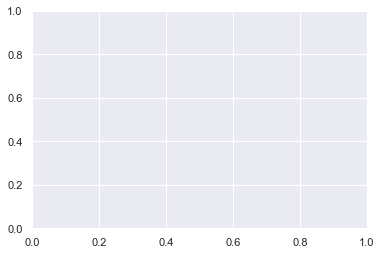

In [87]:
#Función de Autocorrelación Parcial
plot_pacf(df_log_1)

## Modelo Prophet

### $\color{red}{\text{LORE-ALEJO}}$ 

# Conclusiones

### $\color{red}{\text{TODOS}}$ 